## Facial Recogination APP by Siemese Neural Network

### Import dependecies

In [13]:
#set up
!pip install tensorflow 

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [44]:
import cv2                                                                            #importing some standard dependencies
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [45]:
from tensorflow.keras.models import Model                                            # importing tensorflow functional APIs
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [46]:
# can set GPU for memory limit 
# now create folder in my venv and set path for that 

### Create folder structure

In [47]:
POS_PATH = os.path.join('data', 'positive')                                       #creating directory path only
NEG_PATH = os.path.join('data', 'negetive')
ANC_PATH = os.path.join('data', 'anchor')

In [11]:
os.makedirs(POS_PATH)                                                            #making Directories now after path
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

### Collect Positive and Anchor

In [11]:
#getting negetive data from- hhtps://vis-www.cs.umass.edu/lfw
#as the file obtained in tgz file formate(zip folder hence compressed)

                                                                                    #uncompress the tgz file
!tar -xf lfw.tgz 

In [12]:
for directory in os.listdir('lfw'):                           #move LFW image to negetive (data/negetive directory)
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [48]:
#import uuid to generate unique names
import uuid                                 #universally unique identifiers

In [31]:
#accessing webcam and collecting Positive and anchor images
#collecting images of same dimensions as of negetive 

cap = cv2.VideoCapture(0)                   #getting webcam for pictures

while cap.isOpened():                          #looping for the frame
    ret, frame = cap.read()                      #getting frame
    frame[120:120+250, 200:200+250, :]            #resizing frame
    
    #collecting anchors
    if cv2.waitKey(1) & 0XFF == ord('a'): 
        #creating unique path name
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)
        
    
    #collecting positives    
    if cv2.waitKey(1) & 0XFF == ord('p'):     #breaking connecting to webcam
        #creating unique path name
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)
        
    cv2.imshow('my frame', frame)               #showing frame captured
    if cv2.waitKey(1) & 0XFF == ord('q'):     #breaking connecting to webcam
        break

cap.release()
cv2.destroyAllWindows()

### load images and preprocessing

In [49]:
#load and preprocessing of images
#get image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negetive = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

### Preprocessing - scale and resize

In [50]:
def preprocess(file_path):
    #read the image from file path
    byte_img = tf.io.read_file(file_path)
    #load in the image
    img = tf.io.decode_jpeg(byte_img)
    #resize the image means a kind of preprocessing
    img = tf.image.resize(img, (100, 100))
    #pixel range from 0 to 1 only
    img = img/255
    #returning the image
    return img

### Create labelled dataset

In [51]:
#preprocessing the images 
#means scaling and resizing (converting to greyscale image)
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negetives = tf.data.Dataset.zip((anchor, negetive, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negetives)

In [52]:
sample = data.as_numpy_iterator()

In [53]:
example = sample.next()

In [54]:
example

(b'data\\anchor\\44b9fe00-a3d4-11ee-b9f7-b48c9d2e8144.jpg',
 b'data\\positive\\d9abd048-a3d4-11ee-8f79-b48c9d2e8144.jpg',
 1.0)

### Build train and test partitions

In [55]:
def preprocessing_twin(input_img, validation_img, label):
        return (preprocess(input_img), preprocess(validation_img), label)

In [56]:
res = preprocessing_twin(*example)

In [57]:
res[2]

1.0

### Build data load pipeliner

In [58]:
data = data.map(preprocessing_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [59]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [60]:
samples = data.as_numpy_iterator()
sam = samples.next()

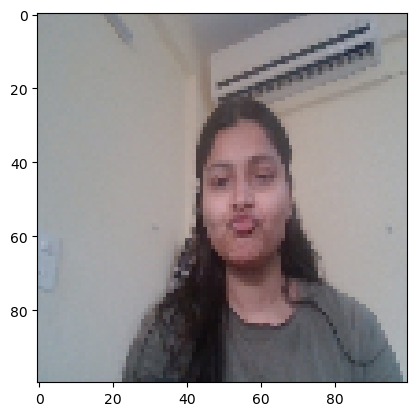

In [61]:
plt.imshow(sam[1])

In [62]:
sam[2]

1.0

### Training Partition

In [63]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [64]:
train_samples = train_data.as_numpy_iterator()

In [65]:
train_sample = train_samples.next()

In [66]:
len(train_sample[1])

16

### Testing Partition

In [67]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Model Engineering

### Building Embedded layer

In [68]:
def make_embedding():
    inp = Input(shape=(100,100,3), name = 'input_image')
    #First Block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    #Second Block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    #Third Block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    #final embedding layer
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp] , outputs=[d1], name='embedding')

In [69]:
embedding = make_embedding()

In [70]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

### Build distance layer

In [71]:
#siamese L1 distance class
class L1Dist(Layer):
    
    #__init__ method for inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    #this is where magic happens- similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [72]:
l1 = L1Dist()

### Make Siamese Model

In [73]:
def make_siamese_model():
    #Anchor image input in the network
    input_image = Input(name= 'input_img', shape=(100, 100, 3))
    
    #Validation image input in the network
    validation_image = Input(name = 'validation_img', shape=(100, 100, 3))
    
    #Commbine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image)) 
    
    #Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')

In [74]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

## Training

### set up loss and Optimiser

In [75]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [76]:
opt = tf.keras.optimizers.Adam(1e-4)

### Establish Checkpoints

In [77]:
checkpoints_dirs = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoints_dirs, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

### Build train step function

In [78]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        #Get anchor and Positive /negetive images
        X = batch[:2]
        #Get label
        Y = batch[2]

        #forward path
        yhat = siamese_model(X, training = True)

        #calculate loss
        loss = binary_cross_loss(Y, yhat)
        
        print(loss)
    #calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    #calculate update weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

### Building training loop

In [79]:
def train(data, EPOCHS):
    #loop through EPOCHS
    for epoch in range(1,  EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        #loop through each batch
        for idx, batch in enumerate(data):
            #run train_step here
            train_step(batch)
            progbar.update(idx+1)
            
        #save checkpoints
        if epoch % 10 == 0 :
            checkpoint.save(file_prefix= checkpoint_prefix)
            

In [80]:
EPOCHS = 50

In [85]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
16/16 [==============================] - 39s 2s/step

 Epoch 2/50
16/16 [==============================] - 39s 2s/step

 Epoch 3/50
16/16 [==============================] - 38s 2s/step

 Epoch 4/50
16/16 [==============================] - 39s 2s/step

 Epoch 5/50
16/16 [==============================] - 44s 3s/step

 Epoch 6/50
16/16 [==============================] - 41s 3s/step

 Epoch 7/50
16/16 [==============================] - 47s 3s/step

 Epoch 8/50
16/16 [==============================] - 45s 3s/step

 Epoch 9/50
16/16 [==============================] - 48s 3s/step

 Epoch 10/50
16/16 [==============================] - 46s 3s/step

 Epoch 11/50
16/16 [==============================] - 45s 3s/step

 Epoch 12/50
16/16 [==============================] - 44s 3s/step

 Epoch 13/50
16/16 [==============================

### Evaluate Model

#### Import Metrices

In [86]:
#import matrix calculation
from tensorflow.keras.metrics import Precision, Recall

##### Make predection

In [87]:
# get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [88]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 656ms/step


In [89]:
y_hat

array([[4.0687164e-06],
       [9.9945098e-01],
       [4.5187330e-12],
       [1.0000000e+00],
       [3.8703124e-07],
       [4.6213823e-05],
       [9.9993712e-01],
       [1.0000000e+00],
       [9.9998766e-01],
       [9.9979001e-01],
       [9.9999881e-01],
       [5.4461960e-08],
       [4.4306617e-10],
       [1.0000000e+00],
       [9.9997538e-01],
       [9.9991858e-01]], dtype=float32)

In [90]:
#post processing the result
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1]

In [91]:
y_true

array([0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.],
      dtype=float32)

#### Calculate Matrices

In [92]:
#create a matrix object
m= Precision()

#Calculating the recall valur
m.update_state(y_true, y_hat)

#return recall result
m.result().numpy()

1.0

In [93]:
#create a matrix object
m= Recall()

#Calculating the recall valur
m.update_state(y_true, y_hat)

#return recall result
m.result().numpy()

1.0

#### Viz Result

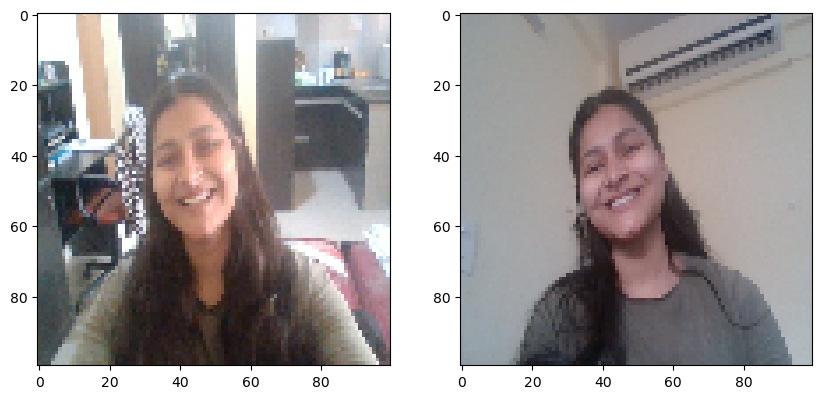

In [94]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[7])
plt.subplot(1,2,2)
plt.imshow(test_val[7])

In [190]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1]